**HW6.Reinforcement learning**
Amirhossein Yousefi 97206984


*Shadlen class*

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from itertools import count
import matplotlib.pyplot as plt
import math
torch.manual_seed(2)

In [ ]:
np.random.seed(1)
num_objects = 10
num_stimuli = 4

class Shadlen:

	def __init__(self):
		self.actions_correctness = []
		self.step = 0
		self.criterion = 0.5
		self.stimuli = self.generate_stimuli(num_stimuli)
		self.state = self.to_one_hot([self.step] + self.stimuli)
	
	def to_one_hot(self, array, N=10):
		array = np.array(array).astype(int)
		labels = np.zeros((array.shape[0], N), dtype=np.float32)
		labels[np.arange(array.shape[0]), array] = 1.
		return labels
		
	def generate_stimuli(self, N_s):
		stimuli = []
		for i in range(N_s):
			stimuli.append(np.random.randint(0, num_objects))
		return stimuli
		
	def reset(self):
		self.__init__()
		return self.state
		
	def response(self, action):
		if self.step == 1:
			GT = float((np.sum(self.stimuli) / (num_objects * num_stimuli)) < self.criterion)
		else:
			GT = float((np.sum(self.stimuli) / (num_objects * num_stimuli)) > self.criterion)
			
		self.actions_correctness.append(GT == action)
		self.step += 1
		
		finished = False
		
		if self.step == 1:
			reward = 0.
			
		elif self.step == 2:
			if self.actions_correctness[-2]:
				reward = 0.
			else:
				finished = True
				if self.actions_correctness[-1]:
					reward = 1.2
				else:
					reward = -2.

		elif self.step == 3:		
			finished = True

			if self.actions_correctness[-2]:
				if self.actions_correctness[-1]:
					reward = 3.5
				else:
					reward = 0.5
			else:
				if self.actions_correctness[-1]:
					reward = 0.
				else:
					reward = -1.					
		else:
			print("StepErr!")
			return

		self.stimuli = self.generate_stimuli(num_stimuli)
		self.state = self.to_one_hot([self.step] + self.stimuli)
		
		return reward, self.state, finished
	shadlen = Shadlen()

In [ ]:
# >>>>>>>>>>>>>>>>>>>> defining monkey_class in order to predicting Q value_function and state
sequence_num=5   
class Monkey(nn.Module):
    def __init__(self,input_size,hidden_size,sequence_num):
        super(Monkey, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size) 
        self.linear = nn.Linear(hidden_size, 2, bias=True)
    def forward(self, x, h0, c0):
        out, (hid,cn)= self.lstm(x.view(sequence_num, 1, -1), (h0, c0)) 
        Q = self.linear(hid.view(1,-1))
        return Q, (hid,cn)
model = Monkey(10,200,5)

In [ ]:
############################################ STRATEGY OF SELECTING ACTION###############################################

### Here we choose action so that at first we prefer exploration but after episodes go on our preference is exploitation-
# so our action selection is probabilistic with high exploration(selecting new action) probabilty at first and then-
# as episodes go by the probability of exploitation plunged.
#hyper_parameter for exploitation vs exploration trade-off is decay 
decay = 20000
Q = torch.zeros(1,2)
init_epsilon = 0.99
final_epsilon = 0.05
stepp = 0
def action_selection_strateg(state, hidden0, cell0):
    global Q 
    global stepp
    rand_act = np.random.rand()
    decay_func = final_epsilon + (init_epsilon - final_epsilon) * math.exp(-1.* stepp / decay)#decay function 
    stepp += 1
    Q, (hiddenn, celln) = model(state, hidden0, cell0)
    if rand_act > decay_func:
        act = np.asscalar(Q.max(1)[1].numpy())      
    else:
        act = np.random.randint(0,2)
    return Q.max(1)[0], act, (hiddenn, celln)

In [ ]:
# >>>>>>>>>>>>>>>>>>>>  train phase the monkey:
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
#num_episode is 50000
loss_fn =nn.MSELoss()
########learning rate is 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
# discount factor is 0.9
gamma = 0.9 
sequence_num=5
####initializing reward and average_reward##########
total_reward = 0
average_reward = []
#hidden_size  is 200
#episode number
for i in range(50000):
    accumulatedloss= 0
    h0 = torch.randn(1, 1, 200)
    c0 = torch.randn(1, 1, 200)
    state = shadlen.reset()
    state = Variable(torch.Tensor(state), requires_grad=True) #  numpy to tensor
    for j in range(3):
        Q, action, (hid,cn) = action_selection_strateg(state, h0, c0)
        reward, next_state, finished = shadlen.response(action)# prediction for Q and next state
        next_state = Variable(torch.Tensor(next_state), requires_grad=True) #  numpy to tensor
        reward = np.array([reward])
        reward = Variable(torch.Tensor(reward), requires_grad=True) #  numpy to tensor
        total_reward += reward
        Qprime, (hid, cn) = model(next_state, hid, cn)
        Qprime = Qprime.max(1)[0]
        (h0, c0) = (hid, cn)
        optimizer.zero_grad()
        if finished:
            loss =  loss_fn(Q, reward)
        else:
            loss =  loss_fn(Q, reward + gamma * Qprime)
        accumulatedloss += loss.item()    
        loss.backward(retain_graph=True)
        optimizer.step()
        if finished:   
            break
        state = next_state
    if i%200 == 0:
        print(f'episode {i}')
        print(f'Q = {Q}')
        print(f'average = {total_reward/200}')
        print(f'loss = {accumulatedloss}')
        average_reward.append(total_reward/200)
        total_reward = 0    
torch.save(model.state_dict(), 'trained_monkey1')   

episode 0
Q = tensor([0.0328], grad_fn=<MaxBackward0>)
average_reward = tensor([-0.0050], grad_fn=<DivBackward0>)
loss = 1.0669307205898804
episode 200
Q = tensor([nan], grad_fn=<MaxBackward0>)
average_reward = tensor([0.0685], grad_fn=<DivBackward0>)
loss = nan
episode 400
Q = tensor([nan], grad_fn=<MaxBackward0>)
average_reward = tensor([0.1255], grad_fn=<DivBackward0>)
loss = nan
episode 600
Q = tensor([nan], grad_fn=<MaxBackward0>)
average_reward = tensor([0.1145], grad_fn=<DivBackward0>)
loss = nan
episode 800
Q = tensor([nan], grad_fn=<MaxBackward0>)
average_reward = tensor([0.1965], grad_fn=<DivBackward0>)
loss = nan
episode 1000
Q = tensor([nan], grad_fn=<MaxBackward0>)
average_reward = tensor([0.2315], grad_fn=<DivBackward0>)
loss = nan
episode 1200
Q = tensor([nan], grad_fn=<MaxBackward0>)
average_reward = tensor([0.2725], grad_fn=<DivBackward0>)
loss = nan
episode 1400
Q = tensor([nan], grad_fn=<MaxBackward0>)
average_reward = tensor([0.4260], grad_fn=<DivBackward0>)
loss = 

In [ ]:
print(new_Q)

tensor([[ 0.0524,  0.0036,  0.0498,  0.1094,  0.0275,  0.0890, -0.0746, -0.0189,
          0.0846,  0.0200,  0.0372,  0.0310,  0.0176,  0.0660,  0.0523,  0.0365,
         -0.0364,  0.0200, -0.0596, -0.0710,  0.0500,  0.0674,  0.0122,  0.0514,
         -0.0325, -0.0341, -0.0793,  0.0083,  0.0243,  0.0402,  0.0442, -0.0398,
         -0.0687, -0.0558,  0.0375, -0.0430, -0.0435, -0.0222,  0.0099, -0.0363,
         -0.0444, -0.0458,  0.0480,  0.0430, -0.0602,  0.0054,  0.0540, -0.0910,
         -0.0718, -0.0290,  0.0122,  0.0252,  0.0483, -0.0132,  0.0281,  0.0226,
          0.0273,  0.0102,  0.0121,  0.0374, -0.0374,  0.0360,  0.0512,  0.0288,
         -0.0076, -0.0624,  0.0775, -0.0874,  0.0374,  0.0843,  0.0530,  0.0708,
          0.0276, -0.0149,  0.0129,  0.0992,  0.0538, -0.0277,  0.1206, -0.0242,
          0.0019,  0.0033, -0.0232, -0.1174, -0.0024,  0.0039,  0.0699, -0.0639,
         -0.0835, -0.0432,  0.0964, -0.0142, -0.0011,  0.0041,  0.0661,  0.0036,
         -0.0623, -0.0215,  

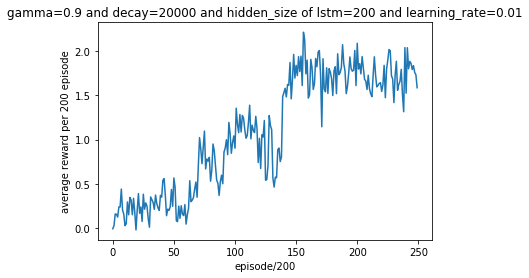

In [ ]:
plt.plot(average_reward)
plt.xlabel('episode/200')
plt.ylabel('average reward per 200 episode')
plt.title(f'gamma={gamma} and decay={decay} and hidden_size of lstm={hidden_size} and learning_rate={lr}')
plt.show()

In [ ]:
#gamma variation
# g1=average_reward
# g2=average_reward
#  g3=average_reward
 g4=average_reward

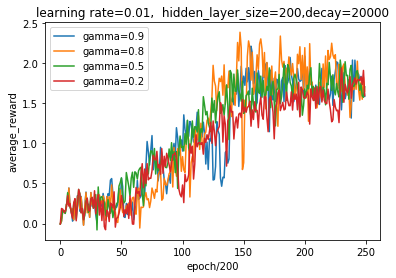

In [ ]:
plt.title('learning rate=0.01,  hidden_layer_size=200,decay=20000')
plt.xlabel('epoch/200')
plt.ylabel('average_reward')
plt.plot(g1, label='gamma=0.9')
plt.plot(g2, label='gamma=0.8')
plt.plot(g3, label='gamma=0.5')
plt.plot(g4, label='gamma=0.2')
plt.legend()
plt.show()

In [ ]:
#hidden size variation
# h1=average_reward
#  h2=average_reward
h3=average_reward
# h4=g1

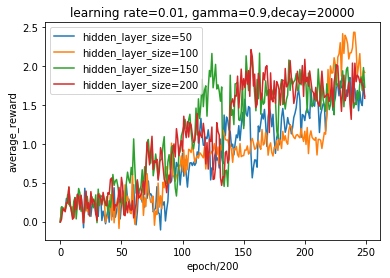

In [ ]:
plt.title('learning rate=0.01, gamma=0.9,decay=20000')
plt.xlabel('epoch/200')
plt.ylabel('average_reward')
plt.plot(h1, label='hidden_layer_size=50')
plt.plot(h2, label='hidden_layer_size=100')
plt.plot(h3, label='hidden_layer_size=150')
plt.plot(h4, label='hidden_layer_size=200')
plt.legend()
plt.show()

In [ ]:
#decay variation
# d1=average_reward
# d2=average_reward
 d3=average_reward
# d4=g1

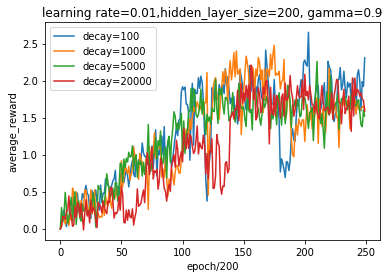

In [ ]:
plt.title('learning rate=0.01,hidden_layer_size=200, gamma=0.9')
plt.xlabel('epoch/200')
plt.ylabel('average_reward')
plt.plot(d1, label='decay=100')
plt.plot(d2, label='decay=1000')
plt.plot(d3, label='decay=5000')
plt.plot(d4, label='decay=20000')
plt.legend()
plt.show()

In [ ]:
# initial epsilon variation
# e1=average_reward
  e2=average_reward
# e3=average_reward
# e4=g1

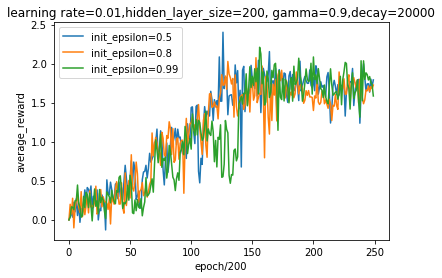

In [ ]:
plt.title('learning rate=0.01,hidden_layer_size=200, gamma=0.9,decay=20000')
plt.xlabel('epoch/200')
plt.ylabel('average_reward')
plt.plot(e2, label='init_epsilon=0.5')
plt.plot(e3, label='init_epsilon=0.8')
plt.plot(e4, label='init_epsilon=0.99')
plt.legend()
plt.show()

In [ ]:
# learning rate variation
# l1=average_reward
# l2=g1
#  l3=average_reward
l4=average_reward

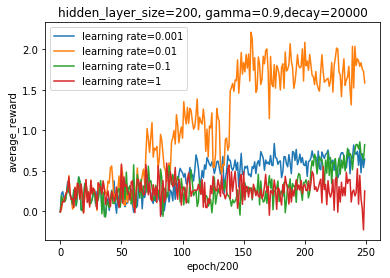

In [ ]:
plt.title('hidden_layer_size=200, gamma=0.9,decay=20000')
plt.xlabel('epoch/200')
plt.ylabel('average_reward')
plt.plot(l1, label='learning rate=0.001')
plt.plot(l2, label='learning rate=0.01')
plt.plot(l3, label='learning rate=0.1')
plt.plot(l4, label='learning rate=1')
plt.legend()
plt.show()